### Machine Learning Group Project


### Teammembers and Contribution

Wong Tung Tung 56221080 
- designed first version 3.2.3.2 Hyperparamter Turning for Deeper CNN

Ng Cheuk Fai 55818427 
- designed XceptionModel

Dario Bogenreiter 40143681 
- wrote Step 0.1 0.2.1, 0.2.2, 0.2.3
- wrote Step 1
- wrote Step 2
- wrote Step 3.2.1, 3.2.2, 3.2.3, 3.2.4
- improved/reworked 3.2.3.2 Hyperparamter Turning for Deeper CNN
- designed the structure of the notebook

# Step 0. Prereqesites

## 0.1 Load necessary libraries

In [1]:
%%capture

# standard libraries
import pandas as pd
import numpy as np
from numpy import *
import sys

# for visuals
import matplotlib.pyplot as plt 
import matplotlib

# handling files
import zipfile
import os
import fnmatch
import regex as re

# dealing with images
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import skimage
import cv2
from skimage import img_as_ubyte
from PIL import Image
from sklearn import *
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.utils import compute_class_weight

#for cleaning up memory
import gc

#for deleting files
import shutil

#for shuffeling the data
import random
from sklearn.utils import shuffle

#for model visuals
!pip install keras==2.8.*
!pip install visualkeras
import visualkeras

#for deep learning
!pip install --upgrade tensorflow==2.8
!pip show tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers.serialization import populate_deserializable_objects
from keras.regularizers import l2


#modifying images
!pip install cvzone
!pip install mediapipe
import cvzone
from cvzone.SelfiSegmentationModule import SelfiSegmentation
import cv2
segmentor = SelfiSegmentation()

# traditional models
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

# hyper-parapemeters tuning
!pip install keras-tuner
from kerastuner import RandomSearch, BayesianOptimization, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

In [2]:
#note I had to run the file on google colab since my processor was too weak
from google.colab import drive

#connect to google drive
drive.mount("/content/gdrive", force_remount=True)
%cd gdrive/My\ Drive/Colab_Notebooks/ML/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab_Notebooks/ML


## 0.2 Defining functions

### 0.2.1. Data Loading functions

In [3]:
def create_data_split_and_directory(train_val_test_split = (0.8, 0.1, 0.1), extract_zip=False):
    """ The following takes the orignal data from a zip or a folder
    and creates approciates directory strucutre with files
    given a split """

    # unzip the orignal data into directory if not already done
    if extract_zip:
      if 'unzipped_data' in os.listdir():
        shutil.rmtree('./unzipped_data/')
      with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
          zip_ref.extractall('./unzipped_data/')
    else:
      pass

    # create data structure
    # delete previous data folder if there was
    # already one earlier, enables us to create new splits easily
    if 'data' in os.listdir():
      shutil.rmtree('./data/')
    # create the folders 
    os.mkdir('./data/')
    os.mkdir('./data/train/')
    os.mkdir('./data/val/')
    os.mkdir('./data/test/')
    # for all subsets create folders to store the label information
    for sub_directory in os.listdir('./data/'):
      os.mkdir('./data/' + sub_directory + '/original/')
      os.mkdir('./data/' + sub_directory + '/manipulated/')

    # open all file names from original data
    all_manipulated_files = []
    all_original_files = []
    for path, subdir, files in os.walk('./unzipped_data/data/'):
        for name in files:
              if fnmatch.fnmatch(name, "*.png"):
                  if "original" in path:
                      all_original_files.append(os.path.join(path, name))
                  elif "manipulated" in path:
                      all_manipulated_files.append(os.path.join(path, name))

    # shuffle the data
    random.shuffle(all_original_files)
    random.shuffle(all_manipulated_files)

    # split the data by moving it into a new directory
    # the try loops are just a precaustion in case
    # we can not evenly split the data
    sub_set_num = 0
    num_all_manipulated = int(len(all_manipulated_files))
    num_all_originals = int(len(all_original_files))
    for data_sub_set in ['train', 'val', 'test']:
      s_to_move = int(num_all_manipulated*train_val_test_split[sub_set_num])
      for file in all_manipulated_files[0:s_to_move]:
        try:
          shutil.copy(file, './data/' + data_sub_set + '/manipulated/') 
        except:
          print(file)
          pass
      all_manipulated_files = all_manipulated_files[s_to_move:]
      
      s_to_move = int(num_all_originals*train_val_test_split[sub_set_num])
      for file in all_original_files[0:s_to_move]:
        try:
          shutil.copy(file, './data/' + data_sub_set + '/original/')
        except:
          print(file)
          pass
      all_original_files = all_original_files[s_to_move:]

      sub_set_num = sub_set_num + 1


def load_color_image(path, imagesize):
    """ simple function
    to open an image from path as color image"""
    # open file
    image = cv2.imread(path)
    # change color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # remove the background
    image = segmentor.removeBG(image, (255, 255, 255), threshold=0.5)
    # change contrast
    # if we set alpha > 1 we will incrase the contrast
    image = cv2.convertScaleAbs(image, alpha=1.2, beta=0)
    # sharpen the imamge
    image = cv2.filter2D(image, -1, np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]))
    # change size
    image = cv2.resize(image, imagesize)
    # return normalized image
    return image/255

def load_bw_image(path, imagesize):
    """ simple function
    to open an image from path as black and white image"""
    # parse it as image parse image as bw image
    sk_bw_image = skimage.io.imread(path, as_gray=True)
    # change size of bw image
    image = resize(sk_bw_image, imagesize, anti_aliasing=True)
    return image/255
      
def load_data(imagesize, path = './data/', bw = False):
    """
    The main functionality to load images as numpy array given a datapath
    Paramater imagesize is a 1x2 array indicating how big the
    loaded image should be, bw meaning if black and white pictures should be loaded.
    """

    # define the datasets
    trainX = []
    trainY = []
    # array to tell us the type of fake
    trainType = []
    valX = []
    valY = []
    valType = []
    testX = []
    testY = []
    testType = []

    if bw == True:
      image_loader = load_bw_image
    else:
      image_loader = load_color_image

    for data_sub_set in ['train', 'val', 'test']:
      for encoded_class, class_name in enumerate(['original', 'manipulated']):
        for path, subdir, files in os.walk('./data/' + data_sub_set + '/' + class_name + '/'):
          for name in files:
                loaded_image = image_loader(os.path.join(path, name), imagesize)
                eval(data_sub_set + 'X' + '.append(loaded_image)')
                eval(data_sub_set + 'Y' + '.append(encoded_class)')
                eval(data_sub_set + 'Type' + '.append(re.sub("\d+\.png", "original", (name.split("_")[0])))')

    # convert to numpy arrays
    trainX = np.array(trainX, dtype = 'float32')  
    trainY = np.array(trainY, dtype = 'int32')
    valX = np.array(valX, dtype = 'float32') 
    valY = np.array(valY, dtype = 'int32')
    testX = np.array(testX, dtype = 'float32')
    testY = np.array(testY, dtype = 'int32')

    # returning scaled images
    return trainX, trainY, trainType, valX, valY, valType, testX, testY, testType

### 0.2.2. Function for Data Analytics

In [4]:
def plot_class_examples(num_examples, images, labels, image_types):
  """ function to plot n example of the two classes
  (orginal and modified ) in our dataset """

  #filter data
  imag_indx_o = np.where(labels == 0)[0][0:num_examples]
  originals = images[imag_indx_o]
  imag_indx_f = np.where(labels == 1)[0][0:num_examples]
  fakes_index = imag_indx_f.tolist()

  # create figure
  fig = plt.figure(figsize=(num_examples*2, 5))
    
  # setting values to rows and column variables
  rows = 2
  columns = num_examples

  position = 1
  for i in originals: 
    fig.add_subplot(rows, columns, position)
    plt.imshow(i)
    plt.title("Orignal Img #"+ str(position))
    plt.axis('off')
    position = position +1

  for index in fakes_index: 
    fig.add_subplot(rows, columns, position)
    plt.imshow(images[index])
    plt.title("Fake of Type\n" + image_types[index])
    plt.axis('off')
    position = position +1

def plot_types(pictures, types):
  """ a function to plot the different 
  type of fakes """
  # create figure
  fig = plt.figure(figsize=(len(pictures)*2, 5))
    
  # setting values to rows and column variables
  rows = 1
  columns = len(pictures)

  position = 1
  for i, pic in enumerate(pictures): 
    fig.add_subplot(rows, columns, position)
    plt.imshow(pic)
    plt.title(types[i] + " Img #"+ str(position))
    plt.axis('off')
    position = position +1


def create_bar_plot(input_Array, title = "Distribution of Types"):
  """
  A simple function to create a bar plot
  based on value counts for a given input array"""

  plt.figure(figsize = (4,3), dpi = 100)
  plt.style.use("seaborn")
  plt.title(title)
  plt.ylabel("Number of Instances")
  plt.xlabel("Image Type")
  pd.Series(input_Array).value_counts().plot(kind="bar")
  _ = plt.xticks(rotation=30)

### 0.2.3. Functions for Visualization & Evaluation of Results

In [29]:

def visualize_prediction(Y, Y_hat, Model_Name, 
                         class_names = ["original", "modified"]):
    """basic function to create confusion matrix
    for predicted and actual values of a model
    and visualize it"""
    
    confusion_matrix = metrics.confusion_matrix(Y, Y_hat)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
    cm_display.plot(cmap = 'Blues', ax = plt.figure(figsize=(2.5,2), dpi=100).add_axes([0, 0, 1, 1])) 
    plt.grid(False)
    plt.title("Confusion Matrix of the " + Model_Name)
    plt.xticks(rotation=40)
    plt.show() 
        
    print("----------------------------------------------------------------")

def evaluate_model(Model, Model_Name, class_names, testX, testY, 
                   trainY = None, trainX = None, skip_train=True):
  
    """ Function to predict values via a given model
    for training and/or test data and then visualizing the results
    """
    
    for i in [[trainX, trainY, "Train"], [testX, testY, "Test"]]:
        X = i[0]
        Y = i[1]
        Set_Name = i[2]
        
        if skip_train == True and Set_Name == "Train":
            continue
        
        print("----------------------------------------------------------------")
        print("Evaluation of " + Model_Name + " on " + Set_Name +  "-Set")

        #doing the prediction
        Y_hat = Model.predict(X)
        #predYtest[Model_Name] = Y_hat

        if "keras.engine" in str(type(Model)):
          Y_hat = np.array(np.round_(Y_hat, decimals = 0, out = None), dtype="int32")
          Y_hat = np.array([x[0] for x in Y_hat.tolist()], dtype="int32")
        
        #outputing accuracy, recall precision and AUC
        accuracy = metrics.accuracy_score(Y, Y_hat)
        recall = metrics.recall_score(Y, Y_hat)
        precision = metrics.precision_score(Y, Y_hat)
        AUC = metrics.roc_auc_score(Y, Y_hat)
        print("Accuracy Score: {:.2f}".format(accuracy))
        print("Recall Score: {:.2f}".format(recall))
        print("Precision Score: {:.2f}".format(precision))
        print("AUC: {:.2f}".format(AUC))
        
        # outputting visual illustration
        visualize_prediction(Y, Y_hat, Model_Name)
        
    print("----------------------------------------------------------------")
    return Y_hat, accuracy, recall, precision, AUC


def plot_training(training_data,train,validation):
    """ Function to visualize the training process
    of a neural network - plots training accuracy
    against validation accuracy """
    plt.style.use('seaborn')
    plt.figure(figsize=(8,3), dpi=80)
    plt.plot(training_data.history[train], color='#6461c2')
    plt.plot(training_data.history[validation], color='#ee0000')
    plt.title('Learning Progress')
    plt.ylabel(train)
    plt.xticks(np.arange(0,len(training_data.history[train]), step=10), 
               np.arange(1,len(training_data.history[train]),  step = 10),  size=13)
    plt.yticks(size=13)
    plt.xlabel('Epoch', size = 13)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


def plot_right_and_wrong_predictions(predYtest, testY, testType, num_examples=5):
    """ A function to plot actual images of examples of 
    correctly and misclassified pictures """

    # get indices of misclassified test images
    ind_bad = np.where(predYtest != testY)[0]
    badimgs = testX[ind_bad][0:num_examples]

    # get indices of correctly classified test images
    ind_good = np.where(predYtest == testY)[0]
    goodimg = testX[ind_good][0:num_examples]

    # create figure
    fig = plt.figure(figsize=(num_examples*1.5, 3.5))
      
    # setting values to rows and column variables
    rows = 2
    columns = num_examples

    #plot positive example
    position = 1
    for i in goodimg: 
      fig.add_subplot(rows, columns, position)
      plt.imshow(i)
      plt.title("Correct \n Prediction #"+ str(position), fontsize=8)
      plt.axis('off')
      position = position +1

    #plot negative examples
    for i in badimgs: 
      fig.add_subplot(rows, columns, position)
      plt.imshow(i)
      plt.title("Wrong \n Prediction #"+ str(position-num_examples), fontsize=8)
      plt.axis('off')
      position = position +1
  
    # visualize how many misclassified we have per image type
    badimgs_types = np.array(testType)[ind_bad]
    #create_bar_plot(badimgs_types)
    #create_bar_plot(testType)
    plt.style.use("seaborn")
    df = pd.DataFrame({'total_samples': pd.Series(testType).value_counts(),
                       'prediction_mistakes':  pd.Series(badimgs_types).value_counts(),
                      }, index=np.unique(testType))

    df.plot(kind="bar", figsize = (5,3), color = {"total_samples": "#a6a6a6", "prediction_mistakes":"#9b111e"} )
    plt.title("Prediction Error per Image Type")
    plt.ylabel("Number of Instances")
    plt.xlabel("Image Type")
    plt.rcParams["figure.dpi"] = 120
    _ = plt.xticks(rotation=30)


# Step 1: Data Loading

In [ ]:
create_data_split_and_directory(train_val_test_split = (0.95, 0.05, 0), extract_zip=False)

In [6]:
#loading the dataset
imagesize = (150,150)
trainX, trainY, trainType, valX, valY, valType, testX, testY, testType = load_data(imagesize)

# shuffling the data  
trainX, trainY, trainType = shuffle(trainX, trainY, trainType)
valX, valY, valType = shuffle(valX, valY, valType)
testX, testY, testType = shuffle(testX, testY, testType)
valY[0:10]

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1], dtype=int32)

In [ ]:
#save to pickle file so we can reload the data more quickly
#with open('saved_data.npy', 'wb') as f:
  #  np.save(f,trainX)
 #   np.save(f,trainY)
  #  np.save(f,trainType)
  #  np.save(f,valX)
 #   np.save(f,valY)
  #  np.save(f,valType)
  #  np.save(f,testX)
  #  np.save(f,testY)
  #  np.save(f,testType)

In [ ]:
#with open('saved_data.npy', 'rb') as f:

  #  trainX = np.load(f)
  #  trainY = np.load(f)
  #  trainType = np.load(f)
  #  valX = np.load(f)
  #  valY = np.load(f)
   # valType = np.load(f)
   # testX = np.load(f)
   # testY = np.load(f)
   # testType= np.load(f)

# Step 2: Data Analytics

Ratio of Manipulated Pictures in Dataset: 0.6666666666666666


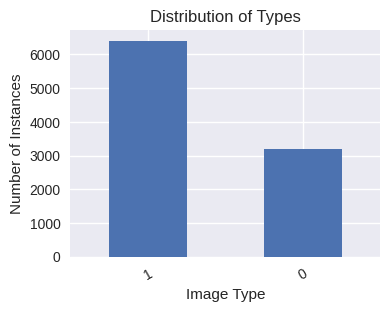

In [ ]:
create_bar_plot(trainY)

print("Ratio of Manipulated Pictures in Dataset: " + str(np.count_nonzero(trainY== 1)  / (np.count_nonzero(trainY== 0)+np.count_nonzero(trainY== 1))))

**Analysis 1: More fakes than orginals**

As I first insight from our data anylsis part we can conslude that we are working with imbalanced data: We have more modified images than real ones. 

**Analysis 2: A lot of data**

As we can see next we are working with about thousand of images meaning computing the model can get really time consuming. Hence it will be valuable to use fast GPUs and resize the image to a size that fits into memory.

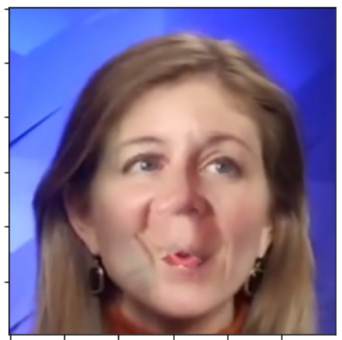

**Analysis 3: Distrating Background**

As we can see next the Background of the images can be sometimes distracting and does not contain any valuable information for us to tell weather the image is a fake or not. Hence we remove it in the data load function.

**Analysis 4: Hard to Spot the Fakes**

Some modified images are hard to stop. As a reaction to this we increase the contrast and sharpness when loading the images. Above you can see an orginal image and below one of our preprocessed images

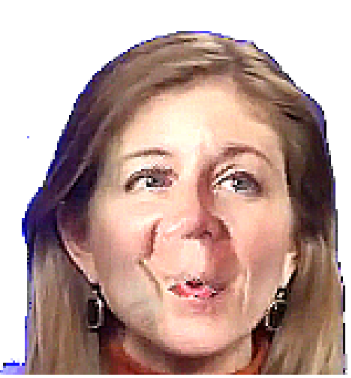

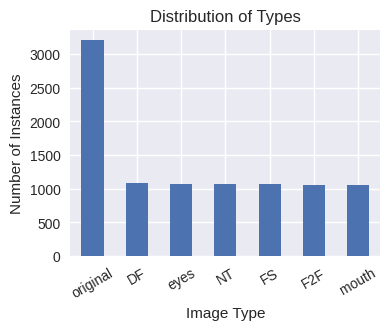

In [ ]:
create_bar_plot(trainType)

**Analysis 5: Different Types of Fakes**

Another insight from the data analysis is that we are dealing with different types of modified pictures. In some of them for example only the mounth is modified or in others just the eyes. As a result it is extremely important to shuffle our data, so that we will not learn to only reognize a few kind of fakes. It is also important to notice that there are an equal number per kind of fake and that the different fake types will be important for our error analysis as well.

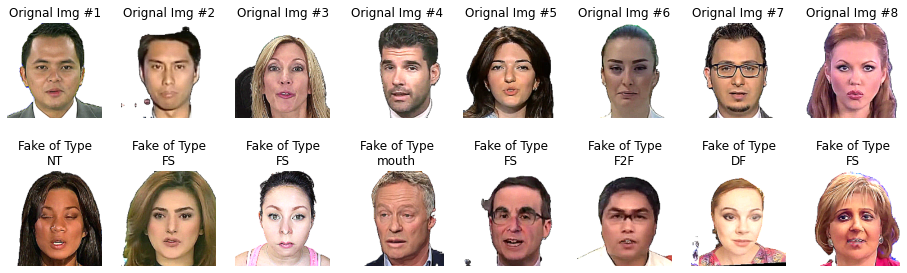

In [ ]:
plot_class_examples(8, trainX, trainY, trainType)

# Step 3. Building Models

## Step 3.1. Traditional Models

### 3.1.0 Data Load and Preprocessing

**Loading the data**

In [ ]:
trainX_bw, trainY, trainType, valX_bw, valY, valType, testX_bw, testY, testType = load_data(imagesize, bw=True)

**Image Flattening & Normalization**

In [ ]:
def flatten_and_normalize(image_array):
  #flattening
  flat_X = empty((len(image_array), prod(imagesize)))
  for i,img in enumerate(image_array):
      flat_X[i,:] = ravel(img)

  #normalization
  scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))  
  flat_X = scaler.fit_transform(flat_X) 
  return flat_X

trainX_bw = flatten_and_normalize(trainX_bw)
valX_bw = flatten_and_normalize(valX_bw)
testX_bw = flatten_and_normalize(testX_bw)

**Do Dimenstionality Reduction**

In [ ]:
#pca = decomposition.PCA(n_components=50)

svd = decomposition.TruncatedSVD(n_components=250)
#transformed x data
trainX_bw_svd = svd.fit_transform(trainX_bw)
trainX_bw_svd  = svd.transform(trainX_bw)
testX_bw_svd  = svd.transform(testX_bw)

### 3.1.1 Cross Validation Search

In [ ]:
clfs = {}
# setup all the parameters and models
exps = {
    #'svm-lin': {
     #   'paramgrid': {'C': logspace(-2,3,5)},
      #  'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,5), 'gamma': logspace(-4,3,5) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [3,4]},
        'clf': svm.SVC(kernel='poly') },
    }

def do_cross_validation_search(exps, trainX, trainY):

  for model_name in exps.keys():
      paramgrid = exps[model_name]['paramgrid']
      estimator = exps[model_name]['clf']

      clf = model_selection.GridSearchCV(estimator, paramgrid, cv=10, n_jobs=-1)
      clf.fit(trainX, trainY)
      print("Best cross-validation for {} score is: {:.3f}, with parameters {} ".format(
                                                                              model_name,
                                                                              clf.best_score_, 
                                                                              clf.best_params_))
      #clfs[model_name] = clf
#do_cross_validation_search(exps, trainX_bw_svd, trainY)

In [ ]:
#build model
SVM_poly = svm.SVC(kernel='poly', C = 0.129, degree=3)
SVM_poly.fit(trainX_bw_svd, trainY)

In [ ]:
evaluate_model(SVM_poly, "SVM Poly", ["original", "modified"],
               testX_bw_svd, testY)

In [ ]:
exps2 = {
    'knn': {
        'paramgrid': {'n_neighbors': arange(2,50,2)},
        'clf': neighbors.KNeighborsClassifier() },
    }

do_cross_validation_search(exps2, trainX_bw_svd, trainY)


In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=48)
knn.fit(trainX_bw_svd, trainY)
evaluate_model(knn, "K Nearest Neighbour", ["original", "modified"], 
               testX_bw_svd, testY)

In [ ]:
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(trainX_bw_svd, testX_bw_svd, 
                              trainY, testY)
models

#### Upsampling the Data

In [ ]:
trainX_bw_svd_upsampled = np.append(trainX_bw_svd, trainX_bw_svd[np.where(trainY==0)[0]], axis=0)
trainY_upsampled = np.append(trainY, trainY[np.where(trainY==0)[0]], axis=0)
print(len(np.where(trainY_upsampled==0)[0]))
print(len(np.where(trainY_upsampled==1)[0]))

In [ ]:
models, predictions = clf.fit(trainX_bw_svd_upsampled, testX_bw_svd, 
                              trainY_upsampled, testY)
models

## Step 3.2. Deep Learning

### 3.2.0 Preperation

**Cleaning Up Memory**

In [ ]:
#del reduced_trainX
#del reduced_testX

gc.collect()

44

**Setting up the Batch Generator**

In [7]:
class BatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


**Choosing the Right Batchsize - MiniBatch Gradient Descent**

According to the Lecture Slides Gradient Descent (GD) theoretically always leads to the best results, as compared to minibatch and stochastic GD. However it is highly computationally expensive. Staochastic GD is by far less computationally expensive, but my lead to noisy steps and may take long to converge. Minibatch GD is essentially a compromise between them. 

The higher batchsize the closer we are to the orginal Gradient Descent which promises the best end results. Hence we are setting the batch size as high as possible. (so that we will not ancounter a RAM error etc.) 


In [8]:
batch_size = 300
train_gen = BatchGenerator(trainX, trainY, batch_size)
val_gen = BatchGenerator(valX, valY, batch_size)
test_gen = BatchGenerator(testX, testY, batch_size)
c_weights = {0: 1.5, 1: 0.75}

### 3.2.1 Initial CNN

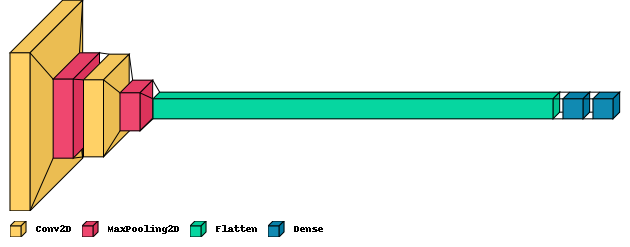

In [ ]:
Simple_CNN = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                           input_shape = (imagesize[0], imagesize[1], 3)), 

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

Simple_CNN.compile(optimizer = keras.optimizers.RMSprop(lr=0.00001,decay=1e-6), 
                   loss = 'binary_crossentropy', metrics=['accuracy'])

visualkeras.layered_view(Simple_CNN, scale_xy =1, legend=True)

In [ ]:
%%capture
history = Simple_CNN.fit(train_gen, epochs=25, validation_data = val_gen)


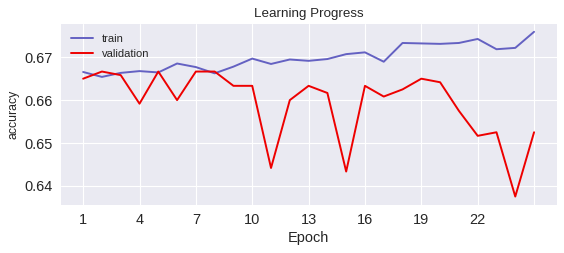

In [ ]:
plot_training(history, 'accuracy', 'val_accuracy')

**Error Analysis 1: Overfitting**

As first issue from the training plot we can identify that our model overfits at some point. We can make this conclusion because we see that the training accuracy is steadily improving, while the validation accuracy is decreasing. Hence, we might need to add regularization methods. As a consequence we introduce dropoutlayers in the next build model. 

----------------------------------------------------------------
Evaluation of Sequential RNN on Test-Set
38/38 [==============================] - 0s 10ms/step
Accuracy Score: 0.65
Recall Score: 0.94
Precision Score: 0.67
AUC: 0.51


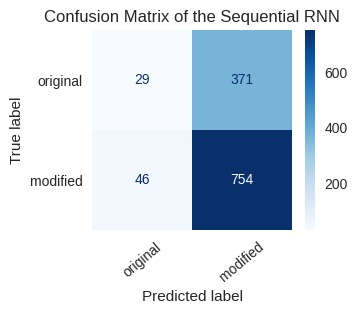

----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
_ = evaluate_model(Simple_CNN, "Sequential RNN", 
               ["original", "manipulated"], testX, testY, skip_train=True)

**Error Analysis 2: The Imbalance Problem**

As we can see from the output of the confusion matrix, our Deep Learning model has problems  is at this point quite useless. It is acting almost as a majority classifier (It is nearly every time predicting the most common class). This issue is most likely caused by the imbalanced data. As a consequence we try to introdue weights in the next steps - so that model gets more incentives to recognize orginal images. 

### 3.2.2. CNN with dropout & Weights

**Dropout Layers**

Dropout layers are a method for regularization. The key idea behind the concept in simple words is that with some probablity P some connections between the layers of our networks will dropout/be deleted when doing the backpropagration the loss to train the weights of the model. As a result the model will learn to not be so dependent on single connections and protentially not overfit. The Probablity P is also called (dropout) rate. In the code we first initialize it with a value of 20%.

Source: Baldi, P., & Sadowski, P. J. (2013). Understanding dropout. Advances in neural information processing systems, 26.

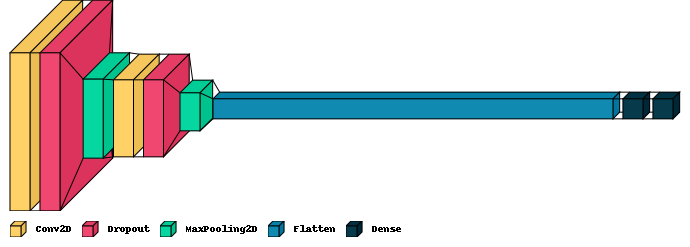

In [ ]:
CNN_with_dropout = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                           input_shape = (imagesize[0], imagesize[1], 3)), 
                           
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

CNN_with_dropout.compile(optimizer = keras.optimizers.RMSprop(lr=0.1,decay=1e-6), 
                         loss = 'binary_crossentropy', metrics=['accuracy'])
visualkeras.layered_view(CNN_with_dropout, scale_xy = 1, legend=True)
#tf.keras.utils.plot_model(model, show_dtype=False, dpi = 70)

**Adding Class weights**

The code below illustrates again our imbalance problem. In order to resolve it we can train out model with weights. Sklearns module compute weights allows us compute the weights that would create a blanced dataset. 

In [ ]:
# show the imbalance problem again
print(len(np.where(trainY == 1)[0]))
print(len(np.where(trainY == 0)[0]))

6400
3200


In [ ]:
# compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(trainY),
                                        y = trainY                                                    
                                    )

# create a dictionary out of the data
c_weights = dict(zip(np.unique(trainY), class_weights))
c_weights

{0: 1.5, 1: 0.75}

In [ ]:
%%capture
#CNN_with_dropout.load_weights('./inital_weights.h5')
CNN_with_dropout.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0005), 
                         loss = 'binary_crossentropy', metrics=['accuracy'])
history = CNN_with_dropout.fit(train_gen, epochs=25, 
                               validation_data = val_gen, class_weight=c_weights)

----------------------------------------------------------------
Evaluation of CNN With Dropout And Weights on Test-Set
38/38 [==============================] - 0s 9ms/step
Accuracy Score: 0.65
Recall Score: 0.65
Precision Score: 0.78
AUC: 0.65


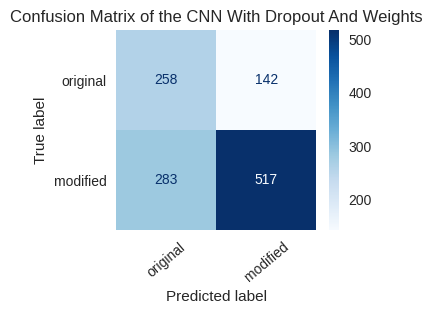

----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:

predictions, accuracy, _, _, _  = evaluate_model(CNN_with_dropout, "CNN With Dropout And Class Weights", ["original", "manipulated"], testX, testY, skip_train=True)

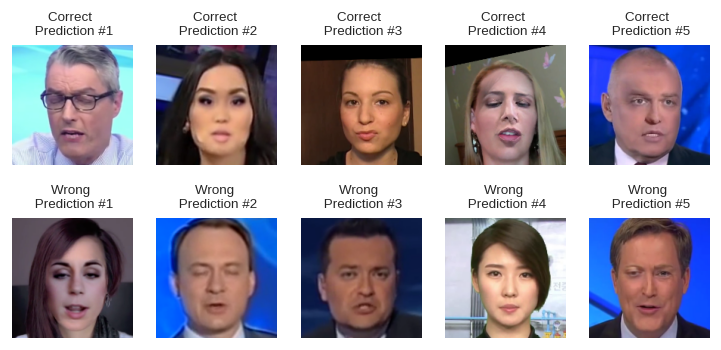

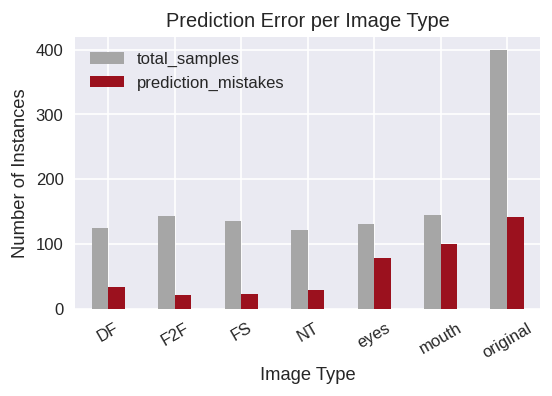

In [ ]:
plot_right_and_wrong_predictions(predictions, testY, testType, 5)

**Error Analysis 3: Weights are effective, but which should we choose**

From the output above we can conclude that adding the weights dramatically improved our result. However, we can spot as well that our model still has problems with identifying original images. As a result it might be of advantage to give these difficult samples even more weight. In the next code cells we try out different weights, to find the optimal value.

In [ ]:
%%capture
# saving the initial weights of the model
CNN_with_dropout.save_weights('./inital_weights.h5')

class_weights_to_try_out = [{0: 1.3, 1: 0.75}, {0: 1.5, 1: 0.75}, {0: 1.7, 1: 0.75}, {0: 2, 1: 0.75}, {0: 2.5, 1: 0.75}]


#set list to collect results
accuracy_results_list = []

for class_weight in class_weights_to_try_out:
  # get inital weights
  CNN_with_dropout.load_weights('./inital_weights.h5')
  # set learning rate
  CNN_with_dropout.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0005), 
                         loss = 'binary_crossentropy', metrics=['accuracy'])
  history = CNN_with_dropout.fit(train_gen, epochs=20, validation_data = val_gen,
                     callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=8)],
                     class_weight=class_weight)
  _, accuracy_score, _, _, _ = evaluate_model(CNN_with_dropout, "Sequential RNN", 
                                              ["original", "manipulated"], 
                                              testX, testY, skip_train=True)
  accuracy_results_list.append(accuracy_score)

In [ ]:
pd.DataFrame({"ClassWeights": [str(i) for i in class_weights_to_try_out],"Accurracy": accuracy_results_list})

,ClassWeights,Accurracy
0,"{0: 1.3, 1: 0.75}",0.61
1,"{0: 1.5, 1: 0.75}",0.62
2,"{0: 1.7, 1: 0.75}",0.59
3,"{0: 2, 1: 0.75}",0.60
4,"{0: 2.5, 1: 0.75}",0.59


**Balanced Weights provide the best results**

From out search for the right paramters for the setting with the balanced weights be get the best result. Hence we keep {0: 1.5, 1: 0.75}	as weight setting for the next points

In [ ]:
c_weights = {0: 1.5, 1: 0.75}	

### 3.2.3. Deeper CNN

As we saw in the last point our model was significantly improved with the latest changed. However the accuracy performance is still below our expectation. Therefore, as a next step of improvement we are adding more layers to our network.

#### 3.2.3.1 Building the Model

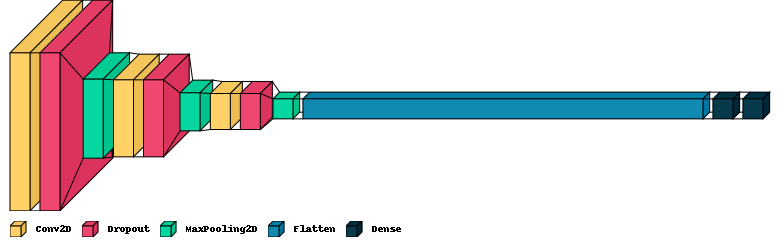

In [ ]:
filter = 16

deeper_CNN = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filter, (3, 3), activation = 'relu', input_shape = (imagesize[0], imagesize[1], 3)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filter*2, (3, 3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filter*2*2, (3, 3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


# compile the model
deeper_CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(deeper_CNN, scale_xy =1, legend=True)

In [ ]:
%%capture
history = deeper_CNN.fit(train_gen,  epochs=35, validation_data = val_gen,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=20)],
                    class_weight=c_weights)

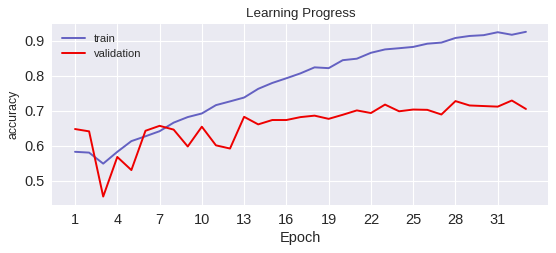

In [ ]:
plot_training(history, 'accuracy', 'val_accuracy')

**Error Analysis 5: Overfitting is still a problem**

From the output above we can see that we are still have not gotten rid of the issue of overfitting. 

----------------------------------------------------------------
Evaluation of Deeper CNN on Test-Set
38/38 [==============================] - 0s 9ms/step
Accuracy Score: 0.70
Recall Score: 0.72
Precision Score: 0.81
AUC: 0.69


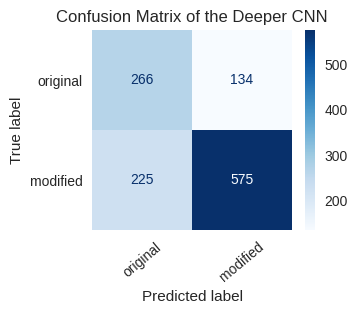

----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
predictions, accuracy, _, _, _  = evaluate_model(deeper_CNN, "Deeper CNN", ["original", "manipulated"], testX, testY, skip_train=True)

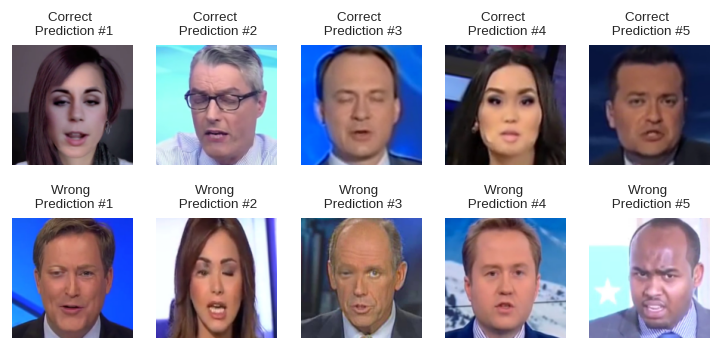

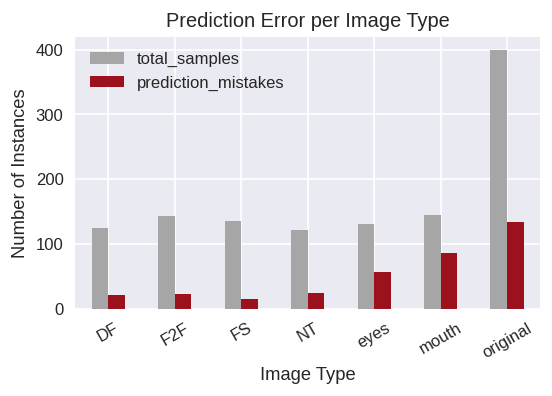

In [ ]:
plot_right_and_wrong_predictions(predictions, testY, testType, 5)

**Error Analysis 6: Our model might still not complex enough**

Our model still lack the reliable ablity in recognizing all DeepFakes. A reason for this could be that we are not using still to few layers or we train them with the wrong learning rate. Hence in the next step we try to add more components to our model and do hyperparamter search for the learning rate and the loss function

**Error Analysis 7: Mouth (and eyes) Fakes seem to be challenging**

As we can see from the bar plot above our model has some issues in identifying those fakes where the mouth or the eyes got faked/modified. As a result we will consider upsampling those images in the training set in the next step.

#### 3.2.3.2 Hyperparamter Turning for Deeper CNN

For hyperparamter tuning we will use the library Keras Tuner (https://keras.io/keras_tuner/). We first set up a function to build our model and call the function hp.Int (for single values) or hp.Choice (for lists) for all the parameters we want to tune. We use again the same architecture as in the pevious section.

In [ ]:
def build_model(hp):

  model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=16, max_value=32, step=16),
                           kernel_size=hp.Choice('conv_1_kernel', values = [3,5]), activation = 'relu', input_shape = (imagesize[0], imagesize[1], 3)),

    tf.keras.layers.Dropout(rate = hp.Choice('dropout_rate_1', values = [0.0,0.05,0.10,0.15,0.25])),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                           kernel_size=hp.Choice('conv_2_kernel', values = [3,5]), activation = 'relu'),
    tf.keras.layers.Dropout(rate =hp.Choice('dropout_rate_2', values = [0.0,0.05,0.10,0.15,0.25])),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
                           kernel_size=hp.Choice('conv_3_kernel', values = [3,5]), activation = 'relu'),
    tf.keras.layers.Dropout(rate =hp.Choice('dropout_rate_3', values = [0.0,0.05,0.10,0.15,0.25])),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=512, step=32),
        activation='relu'
    ),

    tf.keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=7, max_value=130, step=30),
        activation='relu'
    ),

    tf.keras.layers.Dense(1, activation="sigmoid")
])


  hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0002, 0.0001])
  # compile the model
  model.compile(optimizer=keras.optimizers.Adam(hp_learning_rate), loss = 'binary_crossentropy', metrics=['accuracy'])
  return model


**The course of Dimensionality**

Unfortunately, we cannot test all paramters, as this would be too time consuming. In order to still find the most suitable ones in a timely manner, we use BayesianOptimiation which adapts the search for the right parameters by the results of previous searches, and EarlyStopping which stops training early if no improvments in validation accuracy can be seen for a certain number of epochs (in our case we use 3 - that is the patience argument).

Source: https://towardsdatascience.com/grid-search-vs-random-search-vs-bayesian-optimization-2e68f57c3c46

In [ ]:
# creating the tuner object
tuner_search=BayesianOptimization(build_model,
                          objective='val_accuracy',
                          max_trials=50,directory='output',project_name="deep-fake", overwrite=True)

# starting the search
tuner_search.search(train_gen,  epochs=35, validation_data = val_gen,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=3)],
                    class_weight=c_weights)

Trial 50 Complete [00h 00m 26s]
val_accuracy: 0.5841666460037231

Best val_accuracy So Far: 0.7316666841506958
Total elapsed time: 01h 03m 08s


In [ ]:
tuned_deep_CNN = tuner_search.get_best_models(num_models=1)[0]
tuner_search.get_best_hyperparameters()[0].values

{'conv_1_filter': 16,
 'conv_1_kernel': 3,
 'dropout_rate_1': 0.0,
 'conv_2_filter': 32,
 'conv_2_kernel': 5,
 'dropout_rate_2': 0.25,
 'conv_3_filter': 128,
 'conv_3_kernel': 5,
 'dropout_rate_3': 0.15,
 'dense_1_units': 32,
 'dense_2_units': 37,
 'learning_rate': 0.001}

#### 3.2.3.3 Using insights from Hyperparameter Tuning to Build a New Model

**Analysis of the Tuning Results**

Although we were not able to test out all parameter we already get a lot of insights from the result of our search these are the following:

- The dropout layers seem to be valuable to some degree and it is good to use different values for the dropout layers. 

- It is adviseable to use different filters for the convolution layers and the filters should be higher for the later layers.

- Similarly it is good to use different kernel sizes for the conv. The later layers should have a higher kernel size.

- The last dense layer should not be too big in size, in particular it should not be bigger than the size of the last convolution filter which is 128 in our case.

Based on this analysis we are creating a new model:

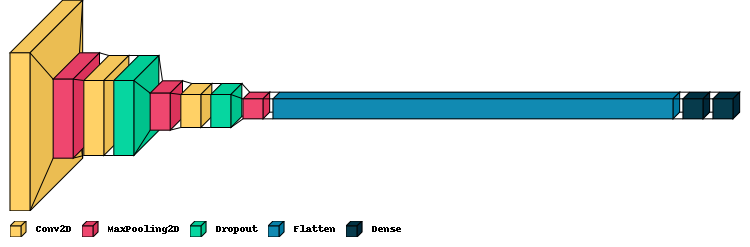

In [ ]:
filter = 16

improved_CNN = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filter, kernel_size=3, activation = 'relu', input_shape = (imagesize[0], imagesize[1], 3)), 
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filter*2, kernel_size=5, activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filter*2*2*2, kernel_size=5, activation = 'relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


# compile the model
improved_CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(improved_CNN, scale_xy =1, legend=True)

In [ ]:
%%capture
history = improved_CNN.fit(train_gen,  epochs=50, validation_data = val_gen,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=15)],
                    class_weight=c_weights)


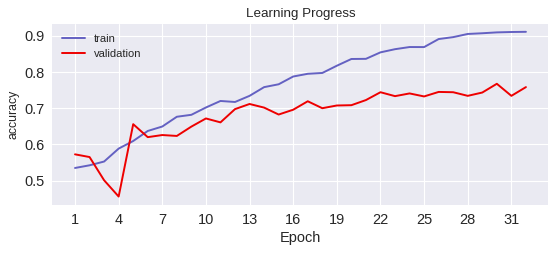

In [ ]:
plot_training(history, 'accuracy', 'val_accuracy')


----------------------------------------------------------------
Evaluation of Improved CNN on Test-Set
38/38 [==============================] - 0s 10ms/step
Accuracy Score: 0.74
Recall Score: 0.77
Precision Score: 0.83
AUC: 0.73


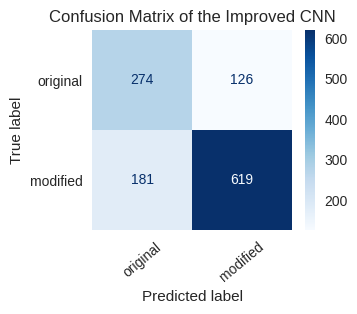

----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
predictions, accuracy, _, _, _  = evaluate_model(improved_CNN, "Improved CNN", ["original", "manipulated"], testX, testY, skip_train=True)

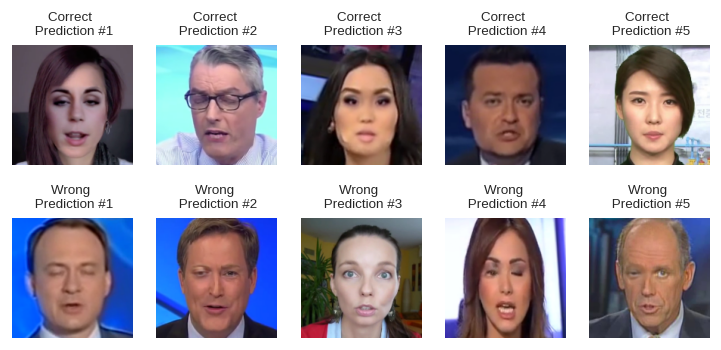

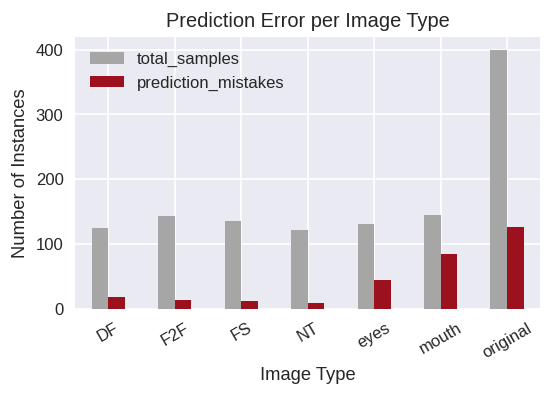

In [ ]:
plot_right_and_wrong_predictions(predictions, testY, testType, 5)

**Error Analysis: We improved accuracy by 4% but still our model overfits**

As we can see from the outputs above we were able to improve our accuracy results on the training search by the insights gathered from doing hyperparameter search. Hence hyperparameter search is a valuable tool for improving deep learning models. However, we still have the issue that our model overfits and that we have a big issues of recognizing DeepFakes where the mouth got notified.

### 3.2.4. Going Even Deeper + Improved Data Loading + Data Augmentation +  Adding more Regularization

In [ ]:
batch_size =300

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./data/train/",
  seed=123,
  image_size=(299, 299),
  shuffle=True,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./data/val/",
  seed=123,
  image_size=(299, 299),
  shuffle=True,
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./data/test/",
  seed=123,
  image_size=(299, 299),
  shuffle=True,
  batch_size=batch_size)

#setting the weights that we discovered earlier
c_weights = {0: 0.75, 1: 1.5}

imagesize=(299,299)

y = np.concatenate([y for x, y in train_ds], axis=0)
print(len(np.where(y == 1)[0]))
print(len(np.where(y == 0)[0]))

#train_ds.map(do_picture_transformation)
#val_ds.map(do_picture_transformation)
#test_ds.map(do_picture_transformation)

In order to improve our model further we add and handle the challenges discussed in the previous points, we introduce more layers. In addition we tune for the right learning rate and loss function. And we introduce weight decay.

#### 3.2.4.0.

https://towardsdatascience.com/writing-a-custom-data-augmentation-layer-in-keras-2b53e048a98

In [9]:
class RandomBrightnessChange(tf.keras.layers.Layer):
    def __init__(self,  
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomBrightnessChange, self).__init__(**kwargs)
        self.brightness_delta = brightness_delta
        
augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.01, input_shape = (imagesize[0], imagesize[1], 3)),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomZoom(0.05),
    RandomBrightnessChange()
    
  ]
)

filter=16
model = tf.keras.Sequential([
      augmentation,
      tf.keras.layers.Conv2D(filter, kernel_size=3, activation = 'relu'), 
      tf.keras.layers.MaxPooling2D(2,2),

      #tf.keras.layers.SeparableConv2D(filter*2, kernel_size=4, activation = 'relu'),
      tf.keras.layers.Conv2D(filter*2, kernel_size=4, activation = 'relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(filter*2*2, kernel_size=5, activation = 'relu'),
      tf.keras.layers.Dropout(0.15),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(filter*2*2*2*2, kernel_size=5, activation = 'relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dense(1, activation="sigmoid")
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(0.0004), loss = "binary_crossentropy", metrics=['accuracy']) 

#### 3.2.4.1. Upsampling Mouth Deep Fakes

In addition we are upsampling the modified images where the mouth was modified. 

In [10]:
trainType = np.array(trainType)

print(len(np.where(trainType=="mouth")[0]))
additional_X_data = trainX[np.where(trainType=="mouth")[0]]
additional_Y_data = trainY[np.where(trainType=="mouth")[0]]
additional_Type_data = trainType[np.where(trainType=="mouth")[0]]

trainY = np.append(trainY, additional_Y_data, axis=0)
trainX = np.append(trainX, additional_X_data, axis=0)
trainType = np.append(trainType, additional_Type_data, axis=0)

# shuffling the data again 
trainX, trainY, trainType = shuffle(trainX, trainY, trainType)
trainY[0:10]



1261


array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1], dtype=int32)

In [11]:
# compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(trainY),
                                        y = trainY                                                    
                                    )

# create a dictionary out of the data
c_weights = dict(zip(np.unique(trainY), class_weights))
c_weights

{0: 1.6659210526315789, 1: 0.7144227513824625}

#### 3.2.4.2. Second Hyperparamter Search

In this next hyperparamter search we are searching for the best learning rate and loss function.

In [ ]:
# creating the tuner object
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=50, directory='output',project_name="deep-fake", overwrite=True)

# starting the search
tuner_search.search(train_gen,  epochs=35, validation_data = val_gen,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=5)],
                    class_weight=c_weights)

tuned_deep_CNN = tuner_search.get_best_models(num_models=1)[0]
tuner_search.get_best_hyperparameters()[0].values

{'learning_rate': 0.0002, 'loss_function': 'binary_crossentropy'}

In [21]:
#%%capture
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

history = model.fit(train_gen,  epochs=50, validation_data = val_gen,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=25)],
                    class_weight=c_weights)

Epoch 1/50
38/38 [==============================] - 2s 55ms/step - loss: 0.0410 - accuracy: 0.9853 - val_loss: 0.4070 - val_accuracy: 0.8783
Epoch 2/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0373 - accuracy: 0.9865 - val_loss: 0.3513 - val_accuracy: 0.8967
Epoch 3/50
38/38 [==============================] - 2s 52ms/step - loss: 0.0353 - accuracy: 0.9869 - val_loss: 0.4452 - val_accuracy: 0.8650
Epoch 4/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0320 - accuracy: 0.9873 - val_loss: 0.5264 - val_accuracy: 0.8767
Epoch 5/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0347 - accuracy: 0.9864 - val_loss: 0.3953 - val_accuracy: 0.8850
Epoch 6/50
38/38 [==============================] - 2s 54ms/step - loss: 0.0238 - accuracy: 0.9911 - val_loss: 0.4310 - val_accuracy: 0.8833
Epoch 7/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0360 - accuracy: 0.9859 - val_loss: 0.4379 - val_accuracy: 0.8783
Epoch 8/50
38

In [22]:
model.save_weights("weights.h5")

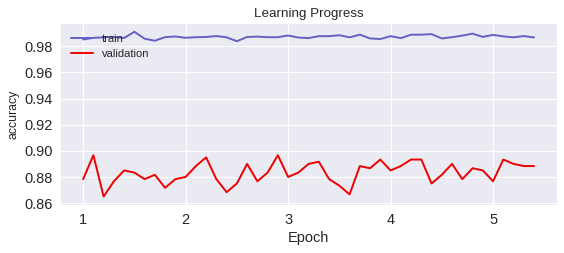

In [26]:
plot_training(history, 'accuracy', 'val_accuracy')

----------------------------------------------------------------
Evaluation of Deep CNN on Test-Set
Accuracy Score: 0.84
Recall Score: 0.83
Precision Score: 0.92
AUC: 0.84


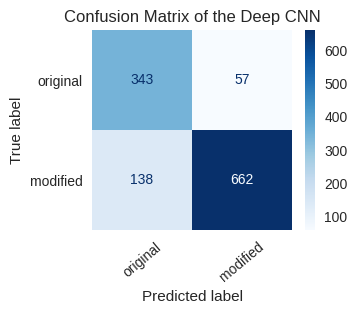

----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
predictions, accuracy, _, _, _  = evaluate_model(model, "Deep CNN", ["original", "manipulated"], testX, testY, skip_train=True)

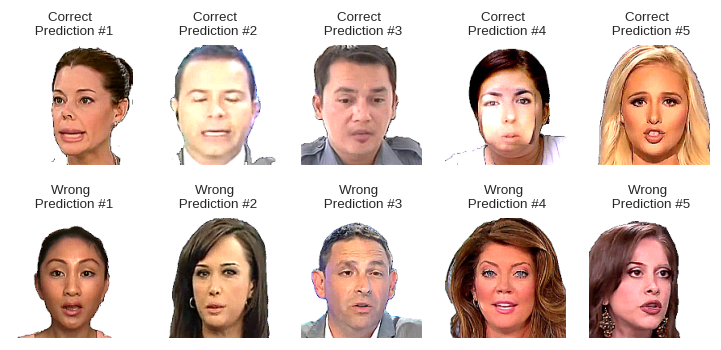

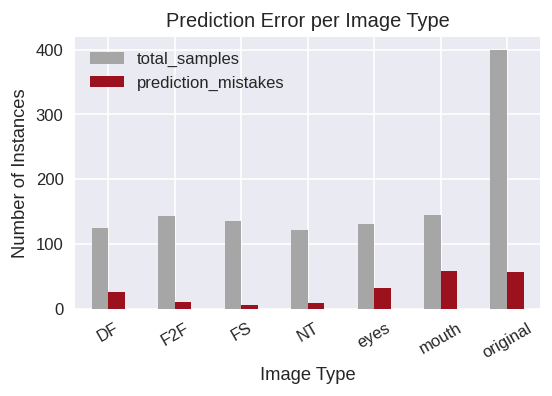

In [ ]:
plot_right_and_wrong_predictions(predictions, testY, testType, 5)

### 3.2.5 Efficient Net

Note: For Efficent Net we have reduced the number of samples else we run
into a Graph execution error

In [ ]:
batch_size = 30
train_gen = BatchGenerator(trainX, trainY, batch_size)
val_gen = BatchGenerator(valX, valY, batch_size)
test_gen = BatchGenerator(testX, testY, batch_size)

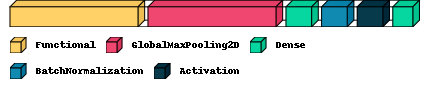

In [ ]:


eff_net = tf.keras.Sequential([
    tf.keras.applications.efficientnet.EfficientNetB0(weights=None,
                                                      include_top=False,  input_shape = (imagesize[0], imagesize[1], 3)),

    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(256, activation=tf.nn.softmax, use_bias=False),

    tf.keras.layers.BatchNormalization(name='batch_norm2'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile the model
eff_net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(eff_net, scale_xy =1, legend=True)


In [ ]:
%%capture
history = eff_net.fit(train_gen, epochs=50, validation_data = val_gen,
                     callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=15)],
                     class_weight=c_weights)

In [ ]:
plot_training(history, 'accuracy', 'val_accuracy')

16705208/16705208 [==============================] - 0s 0us/step


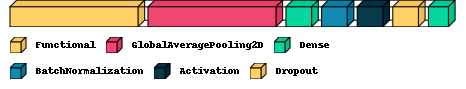

In [ ]:


eff_net = tf.keras.Sequential([
    tf.keras.applications.efficientnet.EfficientNetB0(weights="imagenet",
                                                      include_top=False,  input_shape = (imagesize[0], imagesize[1], 3)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation=tf.nn.softmax, use_bias=False),

    tf.keras.layers.BatchNormalization(name='batch_norm2'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile the model
eff_net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(eff_net, scale_xy =1, legend=True)


In [ ]:
#history = eff_net.fit(train_gen, epochs=10, validation_data = val_gen,
                     #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=8)])
                     #class_weight=c_weights)

In [ ]:
plot_training(history, 'accuracy', 'val_accuracy')

## 5. Appendix

### 5.1. Upsampling

was finally not used because applying class weights works better and more efficient

In [ ]:
print(len(np.where(trainY==0)[0]))
print(len(np.where(trainY==1)[0]))
additional_X_data = trainX[np.where(trainY==0)[0]]
additional_Y_data = trainY[np.where(trainY==0)[0]]
trainY = np.append(trainY, additional_Y_data)
trainX = np.append(trainX, additional_X_data, axis=0)

# shuffle data again
trainX, trainY = shuffle(trainX, trainY)
print(len(trainX))
print(len(trainY))

print(len(np.where(trainY==0)[0]))
print(len(np.where(trainY==1)[0]))